## Solution summary

Train and Test mean pooled image embeddings are extracted from the following models;
* swin_large_patch4_window7_224
* tf_efficientnet_b6_ns,
* convnext-large


Each of the extracted embeddings are then concatenated with the season and growth stage categorical features to create final train and test sets.<br/>
An xgboost regressor is trained on each of the data concatenations via StratifiedKFold cross validation and the average of predictions over all folds is taken for the final test predictions for each embeddings model.<br/>
The final predictions are a weighted average of each of the 3 embeddings models' test predictions

In [4]:
import os
from glob import glob
from dataclasses import dataclass
import gc
import numpy as np
from numpy.linalg import norm
import pandas as pd
import PIL
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from transformers import ViTImageProcessor, AutoModel
from tqdm import tqdm
import xgboost as xgb
import timm

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

In [5]:
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS activated?: {torch.backends.mps.is_built()}")

MPS available: True
MPS activated?: True


In [6]:
@dataclass
class Config:
	device: torch.device = torch.device("mps") # change to from "mps" to "cuda" if using a nvidia gpu
	data_dir: os.PathLike = "./data/"
	n_folds: int = 4
	seed: int = 43098
	batch_size: int = 16
	epochs: int = 3
	eta: float = 3e-4


def RMSE(y_pred, true_value):
	"""Computes the root mean squared error."""
	return np.sqrt(mean_squared_error(y_pred, true_value))

In [7]:
## convert file extensions to lowercase
def file_ext_lowercase(path: os.PathLike):
	"""Lower case file extension."""
	for filename in os.listdir(path):
		if filename.endswith('.JPG'):
			# Generate the new filename with lowercase extension
			new_filename = os.path.join(path, filename.lower())
			# Rename the file
			os.rename(os.path.join(path, filename), new_filename)

#file_ext_lowercase(os.path.join(Config.data_dir, "train"))
#file_ext_lowercase(os.path.join(Config.data_dir, "test"))

In [8]:
train_df = pd.read_csv(os.path.join(Config.data_dir, "Train.csv"))
test_df = pd.read_csv(os.path.join(Config.data_dir, "Test.csv"))
print(f"Train data shape: {train_df.shape}, Num train images: {len(os.listdir(os.path.join(Config.data_dir, 'train')))}\n")
print(f"Train df:\n{train_df.head()}\n")
print(f"Test data shape: {test_df.shape}, Num test images: {len(os.listdir(os.path.join(Config.data_dir, 'test')))}\n")
print(f"Test df:\n{test_df.head()}")


Train data shape: (26068, 6), Num train images: 26068

Train df:
              ID                        filename growth_stage damage  extent  \
0  ID_1S8OOWQYCB  L427F01330C01S03961Rp02052.jpg            S     WD       0   
1  ID_0MD959MIZ0      L1083F00930C39S12674Ip.jpg            V      G       0   
2  ID_JRJCI4Q11V      24_initial_1_1463_1463.JPG            V      G       0   
3  ID_DBO3ZGI1GM  L341F00167C01S00324Rp14178.jpg            M     DR      60   
4  ID_ORZLWTEUUS      L1084F02394C39S13931Ip.jpg            V      G       0   

   season  
0  SR2020  
1  SR2021  
2  LR2020  
3  SR2020  
4  SR2021  

Test data shape: (8663, 5), Num test images: 8663

Test df:
              ID                         filename growth_stage damage  season
0  ID_ROOWKB90UZ   L122F00315C01S02151Rp04021.jpg            V     WD  SR2020
1  ID_PTEDRY0CYM  L1089F03254C01S08845Rp25119.jpg            F     WD  LR2021
2  ID_5WJXDV96R4   L365F01913C39S12578Rp42918.jpg            V     WD  SR2021
3  ID_DM4

Mean damage extent: 7.096056467699862
Standard Deviation of damage extent: 18.61287150126672


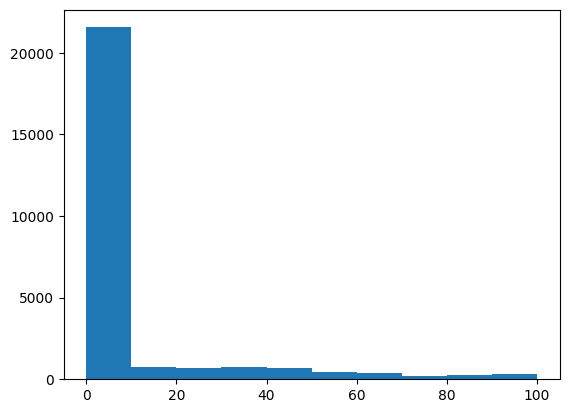

In [9]:
## extent distribution over entire dataset
print(f"Mean damage extent: {np.mean(train_df['extent'].values)}")
print(f"Standard Deviation of damage extent: {np.std(train_df['extent'].values)}")
plt.hist(train_df["extent"]);

In [10]:
# class distributions by group
groups = train_df.groupby("season")["extent"]

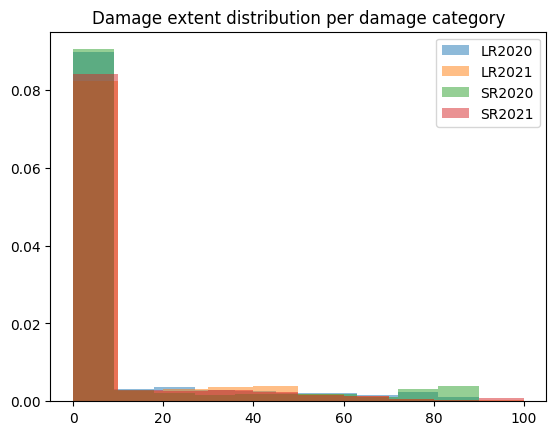

In [11]:
extent = {}
test_df["extent"] = -1
for g_name, group in groups:
	extent[g_name] = np.mean(group)

for g_name, group in groups:
	plt.title("Damage extent distribution per damage category")
	plt.hist(group, alpha=0.5, density=True, label=g_name)
plt.legend()

In [12]:
train_df.describe()

,extent
count,26068.000000
mean,7.096056
std,18.613229
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,100.000000


In [13]:
print(train_df['growth_stage'].value_counts())
print(train_df['season'].value_counts())

growth_stage
V    10015
M     6664
F     6164
S     3225
Name: count, dtype: int64
season
SR2021    9927
LR2021    7945
SR2020    6163
LR2020    2033
Name: count, dtype: int64


In [14]:
# match image filenames to full image path
train_df["images"] = train_df["filename"].apply(lambda x: os.path.join(Config.data_dir, "train", x))
test_df["images"] = test_df["filename"].apply(lambda x: os.path.join(Config.data_dir, "test", x))

# rename files with mismatching names.
rename_idx = list(train_df.loc[train_df["images"].apply(lambda x: "Copy" in x)].index)
for idx in rename_idx:
	corrected_fname = train_df.loc[idx, "images"].split(" - ")[0]+".jpg"
	if os.path.isfile(os.path.join(Config.data_dir, "train", corrected_fname)):
		train_df.loc[idx, "images"] = corrected_fname
	else:
		train_df.drop([idx], axis=0, inplace=True)

train_df["images"] = train_df["images"].apply(lambda x: x.replace(".JPG", ".jpg"))
test_df["images"] = test_df["images"].apply(lambda x: x.replace(".JPG", ".jpg"))
train_df = train_df.drop(["filename"], axis=1).reset_index(drop=True)
test_df = test_df.drop(["filename"], axis=1)
print(train_df.shape)

(26068, 6)


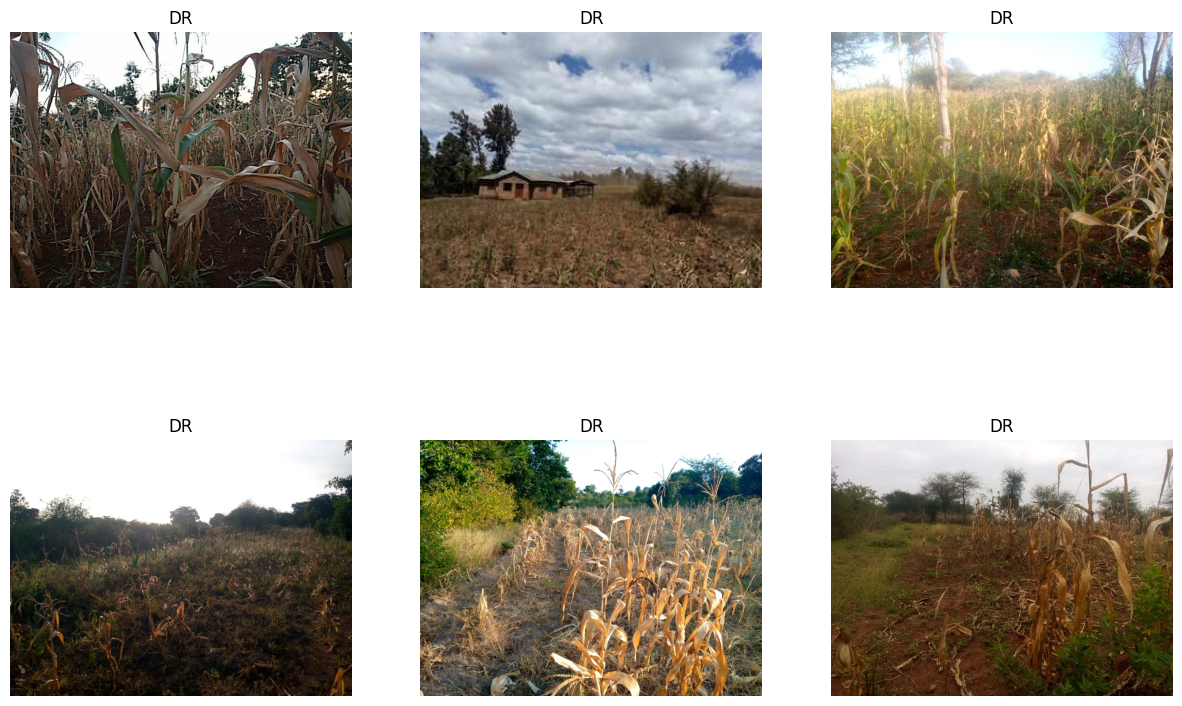

In [15]:
def plot_images(
    df: pd.DataFrame,
    n_samples: int,
    cat: str,
    extent: int,
    seed: int,
    verbose: bool=False
):
    """Visualize a sample of images for a given damage category."""
    plot_list = df[(df["damage"] == cat) & (df["extent"] >= extent)].sample(n_samples, random_state=seed)["images"].tolist()
    if verbose:
        print(f"Sampled Image IDs:\n{plot_list}")

    labels = [cat for i in range(len(plot_list))]
    size = np.sqrt(n_samples)
    if int(size) * int(size) < n_samples:
        size = int(size) + 1

    plt.figure(figsize=(15, 15))
    for idx, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, idx + 1)
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(label, fontsize=12)
        plt.axis("off")

    plt.show()

plot_images(df=train_df, n_samples=6, cat="DR", extent=70, seed=np.random.randint(100), verbose=False)
## ND type images similar to DR, DS images
## Some PS and WD, DR images seem to have similar spatial characteristics for some extent values
## PS and G are almost indistinguishable for images further out of focus with smaller damage extents

In [16]:
## Set non DR damage images' damage extent to 0 (Train csv from aws had non zero values for these)
train_df.loc[(train_df["damage"] != "DR"), "extent"] = 0.0
train_df["extent"].value_counts()

extent
0      21558
10       729
30       727
40       696
20       690
50       445
60       388
90       300
80       291
70       199
100       45
Name: count, dtype: int64

In [17]:
## create folds
skfold = StratifiedKFold(n_splits=Config.n_folds, shuffle=True, random_state=Config.seed)
for i, (train_idx, val_idx) in enumerate(skfold.split(train_df, train_df["extent"]), 1):
	train_df.loc[val_idx, "fold"] = int(i)

train_df.head()

,ID,growth_stage,damage,extent,season,images,fold
0,ID_1S8OOWQYCB,S,WD,0,SR2020,./data/train/L427F01330C01S03961Rp02052.jpg,3.0
1,ID_0MD959MIZ0,V,G,0,SR2021,./data/train/L1083F00930C39S12674Ip.jpg,4.0
2,ID_JRJCI4Q11V,V,G,0,LR2020,./data/train/24_initial_1_1463_1463.jpg,1.0
3,ID_DBO3ZGI1GM,M,DR,60,SR2020,./data/train/L341F00167C01S00324Rp14178.jpg,3.0
4,ID_ORZLWTEUUS,V,G,0,SR2021,./data/train/L1084F02394C39S13931Ip.jpg,2.0


In [18]:
train_df["fold"].value_counts()

fold
3.0    6517
4.0    6517
1.0    6517
2.0    6517
Name: count, dtype: int64

### Extract Image Embeddings

Extract train and test image embeddings using different pretrained vision models

In [25]:
swin_model = timm.create_model(
    "swin_large_patch4_window7_224",
    pretrained=True,
    num_classes=0,
)

convnext_model = timm.create_model(
    "convnext_large",
    pretrained=True,
    num_classes=0,
)

tfenet_model = timm.create_model(
    "tf_efficientnet_b6_ns",
    pretrained=True,
    num_classes=0,
)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b6_ns to current tf_efficientnet_b6.ns_jft_in1k.
  model = create_fn(


In [18]:
data_config = timm.data.resolve_model_data_config(swin_model)
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [21]:
class ImageDataset(Dataset):
	"""CGIAR maize dataset."""
	def __init__(self, data_df, processor, model, timm_data_cfg=False, verbose=False):
		self.data_df = data_df
		self.processor = processor
		self.model = model
		self.timm_cfg = timm_data_cfg

	def __len__(self):
		return self.data_df.shape[0]

	def __getitem__(self, idx):
		image_path = self.data_df.loc[idx, "images"]
		image = PIL.Image.open(image_path).convert("RGB")
		
		if self.timm_cfg:
			# get model specific transforms (normalization, resize)
			data_config = timm.data.resolve_model_data_config(self.model)
			transforms = timm.data.create_transform(**data_config, is_training=False)
			return transforms(image).squeeze(0)
		else:
			image = self.processor(image, return_tensors="pt").pixel_values[0]
			return image


def get_dataloaders(train_df, test_df, processor, model, batch_size, timm_data_cfg=False):
	"""Get ImageDataset data generators."""
	train_df = train_df[["images"]]
	test_df = test_df[["images"]]
	train_dataset = ImageDataset(train_df, processor, model, timm_data_cfg)
	test_dataset = ImageDataset(test_df, processor, model, timm_data_cfg)
	# create dataloaders
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
	test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

	return train_dataloader, test_dataloader


def embeddings_to_disk(embeddings: np.ndarray, filename: str):
	"""Save embeddings to disk as numpy arrays."""
	np.save(filename+".npy", embeddings)
	return 


def get_embeddings(model, data_loader, batch_size, device, is_timm_model=False, aggregate="mean", split="train", verbose=True):
	"""Extract embeddings from input model."""
	model = model.to(device)
	model.eval()
	if split=="train":
		train_image_features = []
		for batch in tqdm(data_loader, total=len(data_loader)):
			if is_timm_model:
				with torch.no_grad():
					output = model.forward_features(batch.to(device))
					image_embeddings = model.forward_head(output, pre_logits=True)
			else:
				with torch.no_grad():
					image_embeddings = model(batch.to(device)).last_hidden_state
					if aggregate == "max":
						image_embeddings = torch.max(image_embeddings, 1)
					else: #"mean"
						image_embeddings = torch.mean(image_embeddings, 1)

			image_embeddings = image_embeddings.squeeze(0).detach().cpu().numpy()
			train_image_features.extend(image_embeddings)
		train_image_features = np.array(train_image_features)
		if verbose:
			print(f"Train embeddings shape: {train_image_features.shape}")
		
		return train_image_features

	else: # split == "test"
		test_image_features = []
		for batch in tqdm(data_loader, total=len(data_loader)):
			if is_timm_model:
				with torch.no_grad():
					output = model.forward_features(batch.to(device))
					image_embeddings = model.forward_head(output, pre_logits=True)
			else:
				with torch.no_grad():
					image_embeddings = model(batch.to(device)).last_hidden_state
					if aggregate == "max":
						image_embeddings = torch.max(image_embeddings, 1)
					else:
						image_embeddings = torch.mean(image_embeddings, 1)
			
			image_embeddings = image_embeddings.squeeze(0).detach().cpu().numpy()
			test_image_features.extend(image_embeddings)

		test_image_features = np.asarray(test_image_features)
		if verbose:
			print(f"Test embeddings shape: {test_image_features.shape}")

		return test_image_features

In [22]:
# Steps run only once embeddings saved to disk
# uncomment to rerun once and load & use saved embeddings on disk for subsequent runs
def fetch_store_embeddings(models: dict, train_df, test_df):
	"""Extract and save embeddings to disk.""" 
	for key, model in models.items():
		print(f"================ Extracting Image embeddings from {key} model =========================")
		train_dataloader, test_dataloader = get_dataloaders(train_df, test_df, None, swin_model, Config.batch_size, timm_data_cfg=True)

		## aggregate arg below should be set to "mean" if mean of embeddings is needed

		train_embeddings = get_embeddings(model, train_dataloader, Config.batch_size, Config.device, is_timm_model=True, aggregate="max", split="train")
		test_embeddings = get_embeddings(model, test_dataloader, Config.batch_size, Config.device, is_timm_model=True, aggregate="max", split="test")

		#Save embeddings to disk
		if not os.path.isdir("./embeddings"):
			os.mkdir("./embeddings")
			
		embeddings_to_disk(train_embeddings, f"./embeddings/{key}_train_embeddings_max")
		embeddings_to_disk(test_embeddings, f"./embeddings/{key}_test_embeddings_max")
		del train_embeddings
		del test_embeddings
		del train_dataloader
		del test_dataloader
		gc.collect()

models = {"swinl": swin_model, "convnext_large": convnext_model, "tfenet": tfenet_model}
fetch_store_embeddings(models, train_df, test_df)

================ Extracting Image embeddings from swinl model =========================


100%|██████████| 1630/1630 [21:07<00:00,  1.29it/s]


Train embeddings shape: (26068, 1536)


100%|██████████| 542/542 [07:02<00:00,  1.28it/s]


Test embeddings shape: (8663, 1536)
================ Extracting Image embeddings from convnext_large model =========================


100%|██████████| 1630/1630 [19:42<00:00,  1.38it/s]


Train embeddings shape: (26068, 1536)


100%|██████████| 542/542 [06:34<00:00,  1.37it/s]


Test embeddings shape: (8663, 1536)
================ Extracting Image embeddings from tfenet model =========================


100%|██████████| 1630/1630 [11:27<00:00,  2.37it/s]


Train embeddings shape: (26068, 2304)


100%|██████████| 542/542 [03:45<00:00,  2.41it/s]


Test embeddings shape: (8663, 2304)


In [23]:
def train_xgb_swin_model(train_df, test_df):
	"""Run xgboost regressor training on swinl mean and max model image embeddings."""
	train_features = np.load(f"./embeddings/swinl_train_embeddings_max.npy")
	train_features_mean = np.load(f"./embeddings/swinl_train_embeddings.npy")
	train_data = train_df.copy()
	train_data = train_data.drop(["ID", "images", "damage"], axis=1)
	train_data = pd.get_dummies(train_data, columns=["growth_stage", "season"])

	test_features = np.load(f"./embeddings/swinl_test_embeddings_max.npy")
	test_ids = test_df["ID"]
	test_data = test_df.copy()
	test_data = test_data.drop(["images", "ID", "extent", "damage"], axis=1)
	test_data = pd.get_dummies(test_data, columns=["growth_stage", "season"])
	test_features = np.concatenate([test_features, test_data.values], axis=1)

	scores = []
	predictions = []
	print(f"================== Training regressor on swinl embeddings =========================")
	for fold in range(1, Config.n_folds+1):
		print(f"======= Fold {fold}========")
		df_train = train_data[train_data["fold"] != fold]
		df_val = train_data[train_data["fold"] == fold]

		train_embeddings = train_features[list(df_train.index), :]
		train_embeddings_mean = train_features_mean[list(df_train.index), :]
		train_embeddings_mean = np.concatenate([train_embeddings_mean, df_train.iloc[:, 2:].values], axis=1)
		train_embeddings = np.concatenate([train_embeddings, df_train.iloc[:, 2:].values], axis=1)
		train_embeddings = np.concatenate([train_embeddings, train_embeddings_mean], axis=0)
		
		target = np.concatenate([df_train["extent"].values, df_train["extent"].values], axis=0)
		val_target = np.concatenate([df_val["extent"].values, df_val["extent"].values], axis=0)

		val_embeddings = train_features[list(df_val.index), :]
		val_embeddings_mean = train_features_mean[list(df_val.index), :]
		val_embeddings_mean = np.concatenate([val_embeddings_mean, df_val.iloc[:, 2:].values], axis=1)
		val_embeddings = np.concatenate([val_embeddings, df_val.iloc[:, 2:].values], axis=1)
		val_embeddings = np.concatenate([val_embeddings, val_embeddings_mean], axis=0)
		
		assert train_embeddings.shape[1] == val_embeddings.shape[1] == test_features.shape[1], \
			f"Train and val embeddings shape mismatch. Got {train_embeddings.shape}, {val_embeddings.shape} & {test_features.shape} respectively."
		xgb_model = xgb.XGBRegressor(
			n_estimators=350,
			max_depth=6,
			max_leaves=150,
			eval_metric="rmse",
			objective="reg:squarederror",
			colsample_bytree=0.9,
			subsample=0.9,
			reg_alpha=1.5,
			learning_rate=0.143,
			base_score=0.0,
			random_state=Config.seed
		)

		xgb_model.fit(train_embeddings, target)
		val_preds = xgb_model.predict(val_embeddings)
		test_preds = xgb_model.predict(test_features)
		score = RMSE(val_target, val_preds)
		scores.append(score)
		print(f"Fold {fold} RMSE: {score}")
		predictions.append(test_preds)
	print(f"Average RMSE over {Config.n_folds}: {np.mean(scores)}")
	print("\n================== Predicting on test set =========================")

	sub_df = pd.DataFrame()
	sub_df["ID"] = test_ids
	sub_df["extent"] = np.mean(predictions, 0)
	sub_df.loc[(sub_df["extent"] < 0), "extent"] = 0
	sub_df.to_csv(f"sub_xgb_swinl_mean_max_emb.csv", index=False)

train_xgb_swin_model(train_df, test_df)

================== Training regressor on swinl embeddings =========================
======= Fold 1========
Fold 1 RMSE: 11.29212362854666
======= Fold 2========
Fold 2 RMSE: 11.431601116656518
======= Fold 3========
Fold 3 RMSE: 11.830275814335915
======= Fold 4========
Fold 4 RMSE: 11.573983541069536
Average RMSE over 4: 11.531996025152157

================== Predicting on test set =========================


In [30]:
## model training
def train_xgb_emb_models(models: dict, train_df, test_df):
	"""Run xgboost regressor training on given models' embeddings."""
	for key, _ in models.items():
		train_features = np.load(f"./embeddings/{key}_train_embeddings_max.npy")
		train_data = train_df.copy()
		train_data = train_data.drop(["ID", "images", "damage"], axis=1)
		train_data = pd.get_dummies(train_data, columns=["growth_stage", "season"])

		test_features = np.load(f"./embeddings/{key}_test_embeddings_max.npy")
		test_ids = test_df["ID"]
		test_data = test_df.copy()
		test_data = test_data.drop(["images", "ID", "extent", "damage"], axis=1)
		test_data = pd.get_dummies(test_data, columns=["growth_stage", "season"])
		test_features = np.concatenate([test_features, test_data.values], axis=1)

		scores = []
		predictions = []
		print(f"================== Training regressor on {key} embeddings =========================")
		for fold in range(1, Config.n_folds+1):
			print(f"======= Fold {fold}========")
			df_train = train_data[train_data["fold"] != fold]
			df_val = train_data[train_data["fold"] == fold]

			train_embeddings = train_features[list(df_train.index), :]
			train_embeddings = np.concatenate([train_embeddings, df_train.iloc[:, 2:].values], axis=1)
			target = df_train["extent"]
			val_target = df_val["extent"]
			
			tar_tmp = df_train["extent"]
			label_freq = tar_tmp.value_counts().sort_index()
			weights = np.where(label_freq.index == 0.0, 0.8, 1.0 / label_freq.values)
			weights = np.repeat(weights, label_freq.values)

			val_embeddings = train_features[list(df_val.index), :]
			val_embeddings = np.concatenate([val_embeddings, df_val.iloc[:, 2:].values], axis=1)
			
			assert train_embeddings.shape[1] == val_embeddings.shape[1] == test_features.shape[1], \
				f"Train and val embeddings shape mismatch. Got {train_embeddings.shape}, {val_embeddings.shape} & {test_features.shape} respectively."
			xgb_model = xgb.XGBRegressor(
				n_estimators=350,
				max_depth=5,
				max_leaves=150,
				eval_metric="rmse",
				objective="reg:squarederror",
				colsample_bytree=0.9,
				subsample=0.9,
				reg_alpha=1.5,
				learning_rate=0.143,
				base_score=0.0,
				random_state=Config.seed
			)

			xgb_model.fit(train_embeddings, target)
			val_preds = xgb_model.predict(val_embeddings)
			test_preds = xgb_model.predict(test_features)
			score = RMSE(val_target, val_preds)
			scores.append(score)
			print(f"Fold {fold} RMSE: {score}")
			predictions.append(test_preds)
		print(f"Average RMSE over {Config.n_folds}: {np.mean(scores)}")
		print("\n================== Predicting on test set =========================")
	
		sub_df = pd.DataFrame()
		sub_df["ID"] = test_ids
		sub_df["extent"] = np.mean(predictions, 0)
		sub_df.loc[(sub_df["extent"] < 0), "extent"] = 0
		sub_df.to_csv(f"sub_xgb_{key}_max_emb.csv", index=False)
		 
		del xgb_model
		del predictions
		del scores
		del df_train
		del df_val
		del train_embeddings
		del val_embeddings
		del sub_df
		del test_ids
		del test_data
		del train_data
		gc.collect()

models = {"convnext_large": convnext_model, "tfenet": tfenet_model}
train_xgb_emb_models(models, train_df, test_df)

================== Training regressor on convnext_large embeddings =========================
======= Fold 1========


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1 RMSE: 11.318036337717777
======= Fold 2========


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2 RMSE: 11.569973200046434
======= Fold 3========


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3 RMSE: 11.896393738683019
======= Fold 4========


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4 RMSE: 11.794104197873644
Average RMSE over 4: 11.644626868580218

================== Predicting on test set =========================
================== Training regressor on tfenet embeddings =========================
======= Fold 1========


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1 RMSE: 12.737752882246484
======= Fold 2========


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2 RMSE: 13.211872593572286
======= Fold 3========


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3 RMSE: 13.276907267797974
======= Fold 4========


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4 RMSE: 12.71769764062452
Average RMSE over 4: 12.986057596060316

================== Predicting on test set =========================


In [36]:
## ensemble predictions
sub_tfenet_svr = pd.read_csv("./sub_xgb_tfenet_max_emb.csv")
sub_swinl_relabel = pd.read_csv("./sub_xgb_swinl_mean_max_emb.csv")
sub_convnext = pd.read_csv("./sub_xgb_convnext_large_max_emb.csv")
sub_swinl_relabel["extent"] = sub_swinl_relabel["extent"] * 0.6 + sub_tfenet_svr["extent"] * 0.15 + sub_convnext["extent"] * 0.4
sub_swinl_relabel.to_csv("sub_swinl_xgb_max.6_tfenet_xgb.15_convnext_xgb.4.csv", index=False)